In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_excel('D:\\Assignments_SCMA632\\Data\\pinksheet.xlsx', sheet_name="Monthly Prices", skiprows=6)


In [3]:
# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

In [4]:
# Convert the Date column to Date format
df['Date'] = pd.to_datetime(df['Date'].astype(str) + "01", format="%YM%m%d")


In [5]:
# Select specific columns (Date and selected commodities)
commodity = df[['Date', df.columns[2], df.columns[24], df.columns[69], df.columns[71], df.columns[60], df.columns[30]]]
commodity.columns = commodity.columns.str.lower().str.replace(' ', '_')

In [6]:
# Remove the Date column for analysis
commodity_data = commodity.drop(columns=['date'])


In [8]:
# Column names to test
columns_to_test = commodity_data.columns

In [9]:
# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

In [16]:
# Loop through each column and perform the ADF test
for col in columns_to_test:
    adf_result = adfuller(commodity_data[col].dropna())
    p_value = adf_result[1]  # Extract p-value for the test
    print(f"\nADF test result for column: {col}\n")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {p_value}")
    print(f"Critical Values: {adf_result[4]}")
    


ADF test result for column: crude_brent

ADF Statistic: -1.5078661910935343
p-value: 0.5296165197702398
Critical Values: {'1%': -3.439006442437876, '5%': -2.865360521688131, '10%': -2.5688044403756587}

ADF test result for column: soybeans

ADF Statistic: -2.4231464527418902
p-value: 0.1353097742779038
Critical Values: {'1%': -3.4388599939707056, '5%': -2.865295977855759, '10%': -2.5687700561872413}

ADF test result for column: gold

ADF Statistic: 1.3430517021933006
p-value: 0.9968394353612382
Critical Values: {'1%': -3.4389608473398194, '5%': -2.8653404270188476, '10%': -2.568793735369693}

ADF test result for column: silver

ADF Statistic: -1.397294710746222
p-value: 0.5835723787985764
Critical Values: {'1%': -3.438915730045254, '5%': -2.8653205426302253, '10%': -2.5687831424305845}

ADF test result for column: urea_ee_bulk

ADF Statistic: -2.5101716315209086
p-value: 0.11301903181624645
Critical Values: {'1%': -3.439006442437876, '5%': -2.865360521688131, '10%': -2.568804440375658

In [79]:
# Check if the p-value is greater than 0.05 (commonly used threshold)
if p_value > 0.05: 
         non_stationary_count += 1
         non_stationary_columns.append(col)
        else:
stationary_columns.append(col)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

In [23]:
# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}")
print(f"Non-stationary columns: {non_stationary_columns}")
print(f"Stationary columns: {stationary_columns}")


Number of non-stationary columns: 0
Non-stationary columns: []
Stationary columns: []


In [26]:
# Co-Integration Test (Johansen's Test)
# Determining the number of lags to use (you can use information criteria like AIC, BIC)
model = VAR(commodity_data.dropna())
lags = model.select_order(maxlags=10)
lag_length = lags.aic

In [28]:
# Johansen's Test for co-integration
coint_test = coint_johansen(commodity_data.dropna(), det_order=0, k_ar_diff=lag_length)


In [29]:
print("\nJohansen Test Results\n")
print("Eigenvalue Test Statistics:\n", coint_test.lr1)
print("Critical Values (90%, 95%, 99%):\n", coint_test.cvt)


Johansen Test Results

Eigenvalue Test Statistics:
 [176.46252708 104.96585715  67.84627098  37.39727549  16.60719811
   5.3013434 ]
Critical Values (90%, 95%, 99%):
 [[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


Det. terms outside the coint. relation & lagged endog. parameters for equation crude_brent
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5111      0.472     -1.083      0.279      -1.436       0.414
L1.crude_brent      0.3290      0.038      8.553      0.000       0.254       0.404
L1.soybeans         0.0065      0.008      0.828      0.408      -0.009       0.022
L1.gold             0.0005      0.006      0.071      0.944      -0.012       0.013
L1.silver          -0.0883      0.162     -0.546      0.585      -0.405       0.229
L1.urea_ee_bulk    -0.0059      0.005     -1.211      0.226      -0.015       0.004
L1.maize            0.0210      0.017      1.212      0.226      -0.013       0.055
L2.crude_brent     -0.0366      0.041     -0.901      0.368      -0.116       0.043
L2.soybeans         0.0136      0.008      1.773      0.076      -0.0

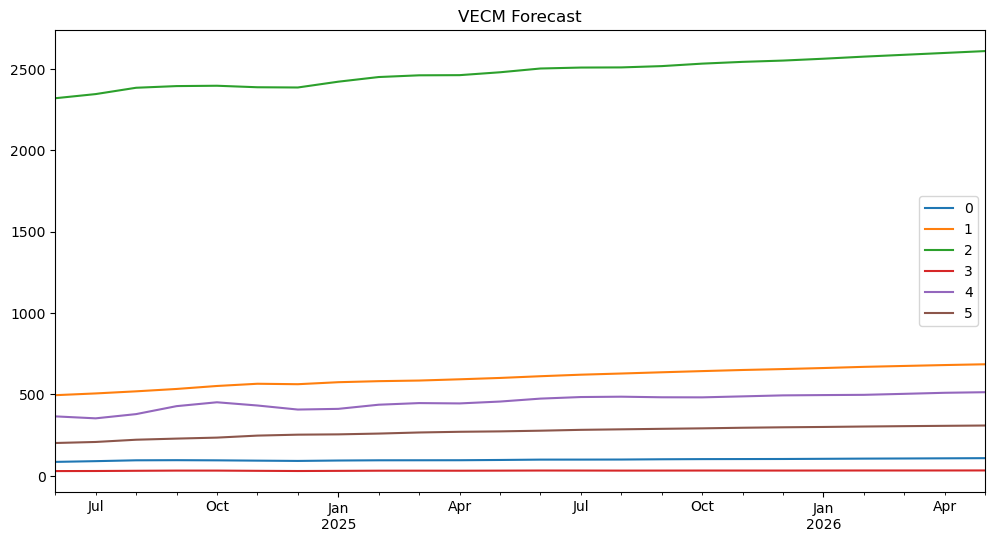

In [30]:
# Determine the number of co-integrating relationships (r) based on the test
# Here, we assume r = 1 if there's at least one significant eigenvalue
r = sum(coint_test.lr1 > coint_test.cvt[:, 1])  # replace 1 with the 5% critical value column index

if r > 0:
    # If co-integration exists, estimate the VECM model
    vecm = VECM(commodity_data.dropna(), k_ar_diff=lag_length, coint_rank=r, deterministic='co')
    vecm_fitted = vecm.fit()
    
    # Summary of the VECM model
    print(vecm_fitted.summary())
    
    # Forecasting using the VECM model
    forecast = vecm_fitted.predict(steps=24)
    
    # Plotting the forecast
    forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=commodity['date'].iloc[-1], periods=24, freq='M'))
    forecast_df.plot(figsize=(12, 6))
    plt.title('VECM Forecast')
    plt.show()

else:
    # If no co-integration exists, proceed with Unrestricted VAR Analysis
    var_model = model.fit(lag_length)
    

In [45]:
var_model = model.fit(lag_length)

In [48]:
# Summary of the VAR model
print (var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Jul, 2024
Time:                     19:48:50
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    27.2744
Nobs:                     765.000    HQIC:                   26.0434
Log likelihood:          -15849.8    FPE:                9.47417e+10
AIC:                      25.2729    Det(Omega_mle):     6.24636e+10
--------------------------------------------------------------------
Results for equation crude_brent
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.567481         0.483126           -1.175           0.240
L1.crude_brent          1.292999         0.039591           32.659           0.000
L1.soybeans             0.009589         0.007

In [55]:
for col in columns_to_test:
        print(f'\nGranger Causality Test for {col}\n')
        print(var_model.test_causality(causing=col, caused=[c for c in columns_to_test if c != col]).summary())
    
    


Granger Causality Test for crude_brent

Granger causality F-test. H_0: crude_brent does not Granger-cause [soybeans, gold, silver, urea_ee_bulk, maize]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         2.026          1.373   0.000 (45, 4260)
------------------------------------------------

Granger Causality Test for soybeans

Granger causality F-test. H_0: soybeans does not Granger-cause [crude_brent, gold, silver, urea_ee_bulk, maize]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         2.658          1.373   0.000 (45, 4260)
------------------------------------------------

Granger Causality Test for gold

Granger causality F-test. H_0: gold does not Granger-cause [crude_brent, soybeans, silver, urea_ee_bulk, maize]. Conclusion: reject H_0 at 5% significance level.
Test stat

In [59]:
# Forecasting using the VAR model
forecast = var_model.forecast(commodity_data.values[-lag_length:], steps=24)
    
   

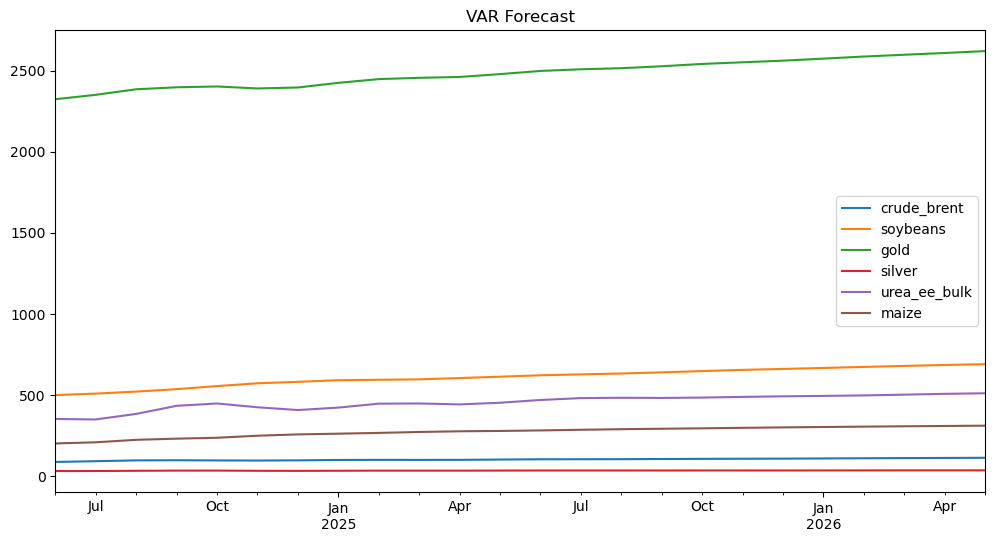

In [62]:
 # Plotting the forecast
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=commodity['date'].iloc[-1], periods=24, freq='M'), columns=commodity_data.columns)
forecast_df.plot(figsize=(12, 6))
plt.title('VAR Forecast')
plt.show()  